In [1]:
import os, sys
sys.path.append('..')
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GCN2Conv, GATConv, global_mean_pool, JumpingKnowledge

from link_prediction.my_util import my_utils

from torch.nn import LSTM

import random
import numpy as np
import pandas as pd
import itertools


from link_prediction.model.temporal_link_predictor import Temporal_Link_Prediction_Model
from link_prediction.my_util import my_utils

import torch

%matplotlib inline

In [2]:
model = Temporal_Link_Prediction_Model(val_ratio=0.2, test_ratio=0.8, data_dir='../../data')

processing Factset in year 2015.
dataset Factset_2015 has been downloaded.
is undirected: False
contains self loops: False
num_nodes: 3260
num_edges: 5611

processing Factset in year 2016.
dataset Factset_2016 has been downloaded.
is undirected: False
contains self loops: False
num_nodes: 3260
num_edges: 8985

processing Factset in year 2017.
dataset Factset_2017 has been downloaded.
is undirected: False
contains self loops: False
num_nodes: 3260
num_edges: 10101

processing Factset in year 2018.
dataset Factset_2018 has been downloaded.
is undirected: False
contains self loops: True
num_nodes: 3260
num_edges: 12158

transformd the graph to undirected.

train test split has been done.
Data(test_neg_edge_index=[2, 5824], test_pos_edge_index=[2, 5824], train_neg_adj_mask=[3260, 3260], train_pos_edge_index=[2, 2], val_neg_edge_index=[2, 1456], val_pos_edge_index=[2, 1456], x=[3260, 435])

train_pos_edge_adj_t is completed.

y_true is completed.

y_train is completed.

data has been sent t

In [3]:
model(
    encode_modelname='EvolveGCNIIO', 
    decode_modelname='Shifted-GAE',
    activation = 'relu', 
    self_loop_mask = True,
    num_hidden_channels = 256, 
    num_layers = 2,
    jk_mode = 'max',
    hidden_channels = None, 
    negative_injection=False,
    dropout = 0.5,
    sigmoid_bias = True,
    negative_sampling_ratio = 1,
    threshold = 0.5
)

######################################
reset the model and the random seed 42.
encode_model: EvolveGCNIIO
decode_model: Shifted-GAE
num_layers: 2
activation: relu
sigmoid_bias: True
negative_injection: False
negative_sampling_ratio: 1
ready to train!



In [4]:
optimizer = {}
optimizer['convs'] = torch.optim.Adam(model.encode_model.convs.parameters(), weight_decay=1e-2, lr=1e-3)
# optimizer['lins'] = torch.optim.Adam(model.encode_model.lins.parameters(), weight_decay=1e-10, lr=1e-1)
optimizer['bias'] = torch.optim.Adam(model.decode_model.bias.parameters(), weight_decay=1e-2, lr=5e-2)
optimizer['recurrents'] = torch.optim.Adam(model.encode_model.recurrents.parameters(), weight_decay=1e-2, lr=1e-3)
model.my_optimizer(optimizer)

scheduler = {}
# scheduler['convs'] = torch.optim.lr_scheduler.StepLR(model.optimizer['convs'], step_size=2, gamma=0.5)
# scheduler['lins'] = torch.optim.lr_scheduler.StepLR(model.optimizer['lins'], step_size=2, gamma=0.5)
scheduler['bias'] = torch.optim.lr_scheduler.ExponentialLR(model.optimizer['bias'], gamma=0.992)
model.my_scheduler(scheduler)

In [5]:
model.run_training(num_epochs=10, print_log=2)

Epoch: 001/010, Train_loss: 2.9246, Val_loss: 0.6289, Val_Score: 0.7353, Best_Val_Score: 0.7353, (Test_loss: 0.6346, Test_score: 0.7365)
Epoch: 002/010, Train_loss: 3.8698, Val_loss: 0.6262, Val_Score: 0.7311, Best_Val_Score: 0.7353, (Test_loss: 0.6320, Test_score: 0.7353)
Epoch: 003/010, Train_loss: 3.3373, Val_loss: 0.6251, Val_Score: 0.7293, Best_Val_Score: 0.7353, (Test_loss: 0.6316, Test_score: 0.7331)
Epoch: 004/010, Train_loss: 3.4888, Val_loss: 0.6243, Val_Score: 0.7151, Best_Val_Score: 0.7353, (Test_loss: 0.6322, Test_score: 0.7128)
Epoch: 005/010, Train_loss: 3.1460, Val_loss: 0.6272, Val_Score: 0.7110, Best_Val_Score: 0.7353, (Test_loss: 0.6358, Test_score: 0.7091)
Epoch: 006/010, Train_loss: 3.3192, Val_loss: 0.6318, Val_Score: 0.7127, Best_Val_Score: 0.7353, (Test_loss: 0.6406, Test_score: 0.7091)
Epoch: 007/010, Train_loss: 3.0750, Val_loss: 0.6380, Val_Score: 0.7128, Best_Val_Score: 0.7353, (Test_loss: 0.6470, Test_score: 0.7034)
Epoch: 008/010, Train_loss: 3.1186, Val_l

../link_prediction/model/temporal_link_predictor.py:669: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:25.)
  val_link_labels = val_link_labels[~np.isnan(val_link_probs)]
../link_prediction/model/temporal_link_predictor.py:670: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:25.)
  val_link_probs = val_link_probs[~np.isnan(val_link_probs)]
../link_prediction/model/temporal_link_predictor.py:674: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:25.)
  test_link_labels = test_link_labels[~np.isnan(test_link_probs)]
../link_prediction/model/temporal_link_predictor.py:675: UserWarning: indexing with dtype torch.uint8 is now deprecat

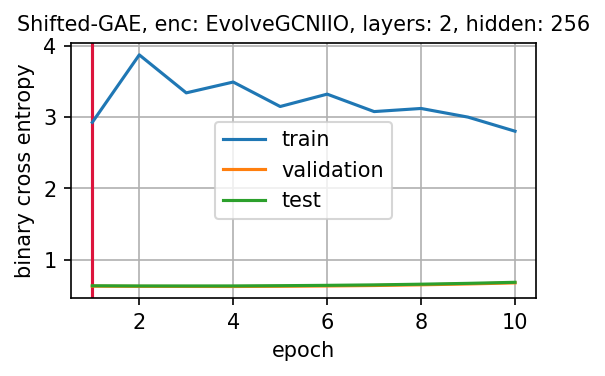

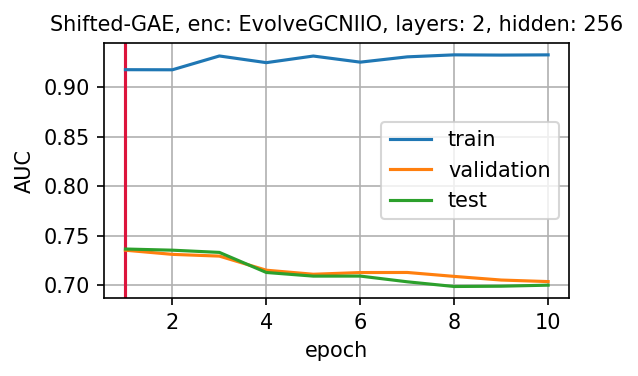

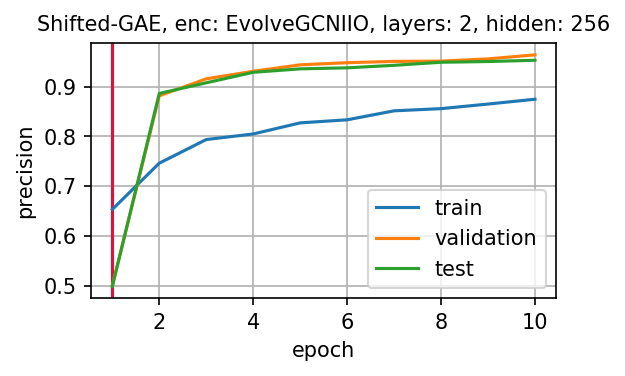

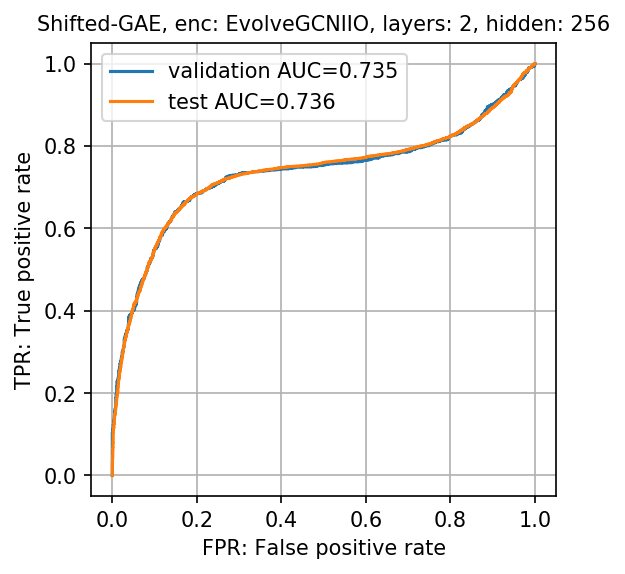

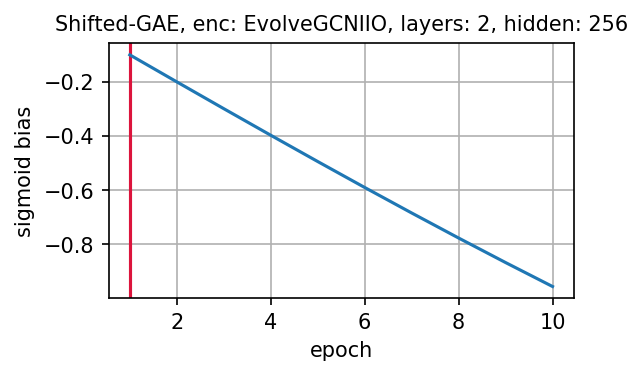

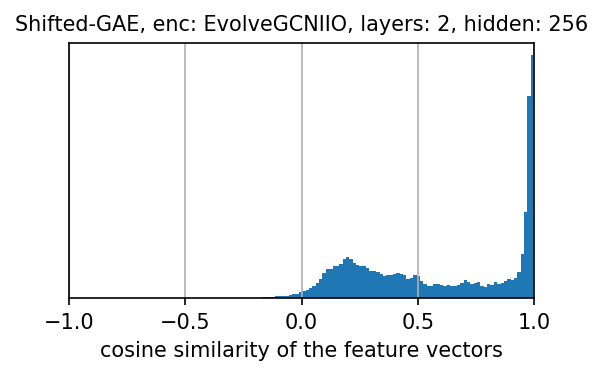

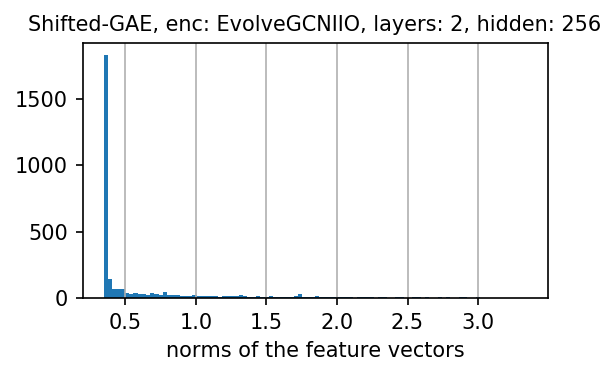

#####val#####
AUC: 0.7354118237531699
val_c_matrix: TP_1292_FP_1289_TN_167_FN_164
accuracy: 0.5010302197802198
precision: 0.5005811700891127
recall: 0.8873626373626373
#####test#####
AUC: 0.7364841291199357
test_c_matrix: TP_5140_FP_5174_TN_650_FN_684
accuracy: 0.49708104395604397
precision: 0.4983517548962575
recall: 0.882554945054945


In [6]:
model.model_evaluate(validation=True, save=True)

In [7]:
torch.stack(model.data_x_seq,0).size()

torch.Size([4, 3260, 435])